In [1]:
import pickle
import numpy as np
import librosa
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
def extract_feature(data, sr, mfcc, chroma, mel):
    if chroma:                          
        stft = np.abs(librosa.stft(data))  
    result = np.array([])
    if mfcc:                          
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:                          
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
        
    if mel:           
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))
        
    return result 

In [4]:
with open("/home/dulat-rakhymkul/Documents/GitHub/Co-GCN/Data/data_processing/Audio/subject_05_aud.pkl", "rb") as f:
    data_aud = pickle.load(f)

with open("/home/dulat-rakhymkul/Documents/GitHub/Co-GCN/Data/data_processing/EEG/subject_05_eeg.pkl", "rb") as f:
    data_eeg = pickle.load(f)

In [5]:
# Unpack data into training and testing features and labels
X_train_aud, y_train_aud, X_test_aud, y_test_aud = data_aud
X_train_eeg, y_train_eeg, X_test_eeg, y_test_eeg = data_eeg

In [6]:
X_train_aud = np.array([extract_feature(s, sr=16000, mfcc=True, chroma=True, mel=True) for s in X_train_aud])
X_test_aud = np.array([extract_feature(s, sr=16000, mfcc=True, chroma=True, mel=True) for s in X_test_aud])

/home/dulat-rakhymkul/Documents/GitHub/GEGCN/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
X_train_aud = torch.tensor(X_train_aud).unsqueeze(1).float()
y_train_aud = torch.tensor(y_train_aud)
X_test_aud = torch.tensor(X_test_aud).unsqueeze(1).float()
y_test_aud = torch.tensor(y_test_aud)

In [8]:
X_train_eeg = torch.tensor(X_train_eeg).float().unsqueeze(1)
X_test_eeg = torch.tensor(X_test_eeg).float().unsqueeze(1)


In [9]:
emotions = ["Neutral", "Sadness", "Anger", "Happiness", "Calmness"]

## Define Data Loader

In [10]:
class PairedModalDataset(Dataset):
    def __init__(self, X_eeg, X_audio, y):
        assert len(X_eeg) == len(X_audio) == len(y)
        self.X_eeg = torch.tensor(X_eeg, dtype=torch.float32)
        self.X_audio = torch.tensor(X_audio, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_eeg[idx], self.X_audio[idx], self.y[idx]

In [11]:
batch_size = 32
y_train = np.array(y_train_aud)

# Paired loaders (used by fusion stages)
train_ds = PairedModalDataset(X_train_eeg, X_train_aud, y_train)
test_ds = PairedModalDataset(X_test_eeg, X_test_aud, y_test_aud)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# Uni-modal loaders matching paper code settings
audio_batch_size = 64
eeg_batch_size = 32

y_train_audio_t = y_train_aud.long() if torch.is_tensor(y_train_aud) else torch.tensor(y_train_aud, dtype=torch.long)
y_test_audio_t = y_test_aud.long() if torch.is_tensor(y_test_aud) else torch.tensor(y_test_aud, dtype=torch.long)
y_train_eeg_t = torch.tensor(y_train_eeg, dtype=torch.long)
y_test_eeg_t = torch.tensor(y_test_eeg, dtype=torch.long)

# CNN_audio
X_train_aud_ref = X_train_aud
X_test_aud_ref = X_test_aud
X_train_eeg_ref = X_train_eeg
X_test_eeg_ref = X_test_eeg

audio_train_loader = DataLoader(TensorDataset(X_train_aud_ref, y_train_audio_t), batch_size=audio_batch_size, shuffle=True)
audio_test_loader = DataLoader(TensorDataset(X_test_aud_ref, y_test_audio_t), batch_size=audio_batch_size, shuffle=True)

# EEGNet
eeg_train_loader = DataLoader(TensorDataset(X_train_eeg_ref, y_train_eeg_t), batch_size=eeg_batch_size, shuffle=True)
eeg_test_loader = DataLoader(TensorDataset(X_test_eeg_ref, y_test_eeg_t), batch_size=eeg_batch_size, shuffle=True)


/tmp/ipykernel_3031179/1497216861.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_train = np.array(y_train_aud)
/tmp/ipykernel_3031179/1108307568.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_eeg = torch.tensor(X_eeg, dtype=torch.float32)
/tmp/ipykernel_3031179/1108307568.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_audio = torch.tensor(X_audio, dtype=torch.float32)
/tmp/ipykernel_3031179/1108307568

In [12]:
X_test_eeg_ref.shape

torch.Size([120, 1, 30, 500])

## Models

EEGNet + AudioSCNN backbones are preserved.
Only the graph fusion stage below is replaced: Co-GCN -> repository GEGCN framework.


In [13]:
class FusionLateHead(nn.Module):
    def __init__(self, eeg_model, audio_model, num_classes, hidden=256, p_drop=0.2):
        super().__init__()
        self.eeg = eeg_model
        self.audio = audio_model

        # Freeze experts
        for p in self.eeg.parameters():   p.requires_grad = False
        for p in self.audio.parameters(): p.requires_grad = False
        self.eeg.eval()
        self.audio.eval()

        in_dim = self.eeg.dense.in_features + self.audio.classifier.in_features
        self.head = nn.Linear(in_dim, num_classes)

    def forward(self, x_eeg, x_audio):
        logits_eeg, feat_eeg = self.eeg(x_eeg, return_features=True)
        logits_audio, feat_audio = self.audio(x_audio, return_features=True)
        fused_in = torch.cat([feat_eeg, feat_audio], dim=1)
        out = self.head(fused_in)                                  # [B, C]
        return out, logits_eeg, logits_audio


In [14]:
from model import EEGNet, EEGNet_tor, AudioSCNN

n_class = len(emotions)

eeg_backbone = EEGNet_tor(
    nb_classes=n_class,
    Samples=500,
    Chans=30,
    dropoutRate=0.5,
    kernLength=300,
    F1=8,
    D=8,
    F2=16,
).to(device)
optim_eeg = Adam(eeg_backbone.parameters(), lr=1e-3)
criterion_eeg = nn.CrossEntropyLoss()

aud_backbone = AudioSCNN(num_classes=n_class).to(device)
optim_aud = Adam(aud_backbone.parameters(), lr=1e-3, weight_decay=1e-6)
criterion_aud = nn.CrossEntropyLoss()


## Train Backbone Models Separately

In [15]:
def train_audio(model, optimizer, criterion, train_loader, test_loader, epochs=100, device='cpu'):
    model.to(device)
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct, train_total = 0, 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (out.argmax(dim=1) == y).sum().item()
            train_total += y.size(0)

        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / 100.0)

        model.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)

                out = model(x)
                test_correct += (out.argmax(dim=1) == y).sum().item()
                test_total += y.size(0)

        print(
            f"Epoch [{epoch + 1}/{epochs}] | "
            f"Train Loss: {train_loss / len(train_loader):.4f} | "
            f"Train Acc: {train_acc:.2f}% | "
        )

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            all_preds.extend(out.argmax(dim=1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    final_test_acc = accuracy_score(all_labels, all_preds)
    final_test_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Final Test Accuracy = {final_test_acc * 100:.2f}%")
    print(f"Final Test F1 = {final_test_f1:.4f}")

    return model, train_losses, train_accuracies, final_test_acc, final_test_f1


In [16]:
def train_eeg(model, optimizer, criterion, train_loader, test_loader, epochs=100, device='cpu'):
    model.to(device)
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)

            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_acc = 100 * train_correct / train_total

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / 100.0)

        print(
            f"Epoch {epoch + 1}/{epochs} | "
            f"Train Loss: {train_loss/len(train_loader):.4f} | "
            f"Train Acc: {train_acc:.4f} | "
        )
    
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            outputs = model(inputs)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    final_test_acc = accuracy_score(all_labels, all_preds)
    final_test_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Final Test Accuracy = {final_test_acc * 100:.2f}%")
    print(f"Final Test F1 = {final_test_f1:.4f}")
    return model, train_losses, train_accuracies, final_test_acc, final_test_f1


In [17]:
def train_fusion(model, optimizer, criterion, train_loader, test_loader, epochs=100, device="cpu"):
    # using test set as validation here
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_epoch_loss = 0
        train_correct = 0
        train_total = 0
        for eeg, audio, labels in train_loader:
            eeg = eeg.to(dtype=torch.float32, device=device)
            audio = audio.to(dtype=torch.float32, device=device)
            labels = labels.to(device=device)

            optimizer.zero_grad()
            outputs, _, _ = model(eeg, audio)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.numel()

        train_epoch_loss = train_epoch_loss / len(train_loader)
        train_epoch_acc = train_correct / train_total if train_total else 0.

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_acc)

    
        print(f"Epoch {epoch+1} |"
              f"Train Loss: {train_epoch_loss:.3f} |"
              f"Train Acc: {train_epoch_acc * 100 :.2f}%")

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for eeg, audio, labels in test_loader:
            eeg = eeg.to(dtype=torch.float32, device=device)
            audio = audio.to(dtype=torch.float32, device=device)
            labels = labels.to(device=device)

            outputs, _, _ = model(eeg, audio)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    best_test_acc = accuracy_score(all_labels, all_preds)
    best_test_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Final Test Accuracy = {best_test_acc * 100:.2f}%")
    print(f"Final Test F1 = {best_test_f1:.4f}")

    return model, train_losses, train_accuracies

In [18]:
print("Training Audio model (paper settings)")
aud_backbone, train_losses_aud, train_accs_aud, final_test_acc_aud, final_test_f1_aud = train_audio(
    aud_backbone,
    optim_aud,
    criterion_aud,
    audio_train_loader,
    audio_test_loader,
    epochs=100,
    device=device,
)


Training Audio model (paper settings)
Epoch [1/100] | Train Loss: 2.3588 | Train Acc: 17.50% | 
Epoch [2/100] | Train Loss: 1.7079 | Train Acc: 26.07% | 
Epoch [3/100] | Train Loss: 1.6459 | Train Acc: 20.71% | 
Epoch [4/100] | Train Loss: 1.6121 | Train Acc: 23.93% | 
Epoch [5/100] | Train Loss: 1.4928 | Train Acc: 35.36% | 
Epoch [6/100] | Train Loss: 1.3712 | Train Acc: 39.64% | 
Epoch [7/100] | Train Loss: 1.2605 | Train Acc: 43.57% | 
Epoch [8/100] | Train Loss: 1.1041 | Train Acc: 51.43% | 
Epoch [9/100] | Train Loss: 1.1135 | Train Acc: 52.14% | 
Epoch [10/100] | Train Loss: 1.0597 | Train Acc: 56.43% | 
Epoch [11/100] | Train Loss: 0.9863 | Train Acc: 55.36% | 
Epoch [12/100] | Train Loss: 0.9487 | Train Acc: 59.29% | 
Epoch [13/100] | Train Loss: 0.8474 | Train Acc: 63.93% | 
Epoch [14/100] | Train Loss: 0.8504 | Train Acc: 60.36% | 
Epoch [15/100] | Train Loss: 0.8441 | Train Acc: 66.79% | 
Epoch [16/100] | Train Loss: 0.7847 | Train Acc: 65.36% | 
Epoch [17/100] | Train Loss

In [19]:
PATH = "./Models/audio_scnn.pth"
torch.save(aud_backbone.state_dict(), PATH)


In [20]:
print("Training EEGNet (paper settings)")
eeg_backbone, train_losses_eeg, train_accs_eeg, final_test_acc_eeg, final_test_f1_eeg = train_eeg(
    eeg_backbone,
    optim_eeg,
    criterion_eeg,
    eeg_train_loader,
    eeg_test_loader,
    epochs=100,
    device=device,
)


Training EEGNet (paper settings)
Epoch 1/100 | Train Loss: 1.6086 | Train Acc: 22.5000 | 
Epoch 2/100 | Train Loss: 1.5720 | Train Acc: 36.7857 | 
Epoch 3/100 | Train Loss: 1.5260 | Train Acc: 46.0714 | 
Epoch 4/100 | Train Loss: 1.5176 | Train Acc: 42.5000 | 
Epoch 5/100 | Train Loss: 1.5062 | Train Acc: 41.0714 | 
Epoch 6/100 | Train Loss: 1.4755 | Train Acc: 47.5000 | 
Epoch 7/100 | Train Loss: 1.4442 | Train Acc: 54.2857 | 
Epoch 8/100 | Train Loss: 1.4218 | Train Acc: 59.2857 | 
Epoch 9/100 | Train Loss: 1.4148 | Train Acc: 58.2143 | 
Epoch 10/100 | Train Loss: 1.4001 | Train Acc: 56.0714 | 
Epoch 11/100 | Train Loss: 1.3805 | Train Acc: 59.6429 | 
Epoch 12/100 | Train Loss: 1.3507 | Train Acc: 65.0000 | 
Epoch 13/100 | Train Loss: 1.3404 | Train Acc: 66.7857 | 
Epoch 14/100 | Train Loss: 1.3087 | Train Acc: 69.6429 | 
Epoch 15/100 | Train Loss: 1.3142 | Train Acc: 70.7143 | 
Epoch 16/100 | Train Loss: 1.2851 | Train Acc: 71.4286 | 
Epoch 17/100 | Train Loss: 1.2881 | Train Acc: 7

Epoch 25/100 | Train Loss: 1.1947 | Train Acc: 78.9286 | 
Epoch 26/100 | Train Loss: 1.1914 | Train Acc: 80.3571 | 
Epoch 27/100 | Train Loss: 1.1886 | Train Acc: 78.2143 | 
Epoch 28/100 | Train Loss: 1.1901 | Train Acc: 77.8571 | 
Epoch 29/100 | Train Loss: 1.1882 | Train Acc: 84.2857 | 
Epoch 30/100 | Train Loss: 1.1607 | Train Acc: 83.9286 | 
Epoch 31/100 | Train Loss: 1.1796 | Train Acc: 79.6429 | 
Epoch 32/100 | Train Loss: 1.1523 | Train Acc: 84.6429 | 
Epoch 33/100 | Train Loss: 1.1362 | Train Acc: 85.0000 | 
Epoch 34/100 | Train Loss: 1.1464 | Train Acc: 84.6429 | 
Epoch 35/100 | Train Loss: 1.1397 | Train Acc: 84.2857 | 
Epoch 36/100 | Train Loss: 1.1272 | Train Acc: 85.3571 | 
Epoch 37/100 | Train Loss: 1.1362 | Train Acc: 85.0000 | 
Epoch 38/100 | Train Loss: 1.1182 | Train Acc: 87.5000 | 
Epoch 39/100 | Train Loss: 1.1286 | Train Acc: 84.2857 | 
Epoch 40/100 | Train Loss: 1.1120 | Train Acc: 87.8571 | 
Epoch 41/100 | Train Loss: 1.0830 | Train Acc: 89.6429 | 
Epoch 42/100 |

In [21]:
PATH = "./Models/eeg_cnn.pth"
torch.save(eeg_backbone.state_dict(), PATH)


In [22]:
eeg_backbone.load_state_dict(torch.load("./Models/eeg_cnn.pth", map_location=device))
aud_backbone.load_state_dict(torch.load("./Models/audio_scnn.pth", map_location=device))


<All keys matched successfully>

In [23]:
fusion = FusionLateHead(eeg_backbone, aud_backbone, num_classes=n_class, hidden=256, p_drop=0.2).to(device)
optim_fusion = torch.optim.AdamW(fusion.head.parameters(), lr=5e-4, weight_decay=1e-4)
criterion_fusion = nn.CrossEntropyLoss()

In [24]:
print("Training Fusion model")
fusion, train_losses_fusion, train_accs_fusion = train_fusion(fusion, optim_fusion, criterion_fusion, train_loader, test_loader, epochs=100, device=device)

Training Fusion model
Epoch 1 |Train Loss: 1.183 |Train Acc: 51.07%
Epoch 2 |Train Loss: 0.375 |Train Acc: 96.07%
Epoch 3 |Train Loss: 0.169 |Train Acc: 98.57%
Epoch 4 |Train Loss: 0.125 |Train Acc: 98.21%
Epoch 5 |Train Loss: 0.083 |Train Acc: 100.00%
Epoch 6 |Train Loss: 0.066 |Train Acc: 99.29%
Epoch 7 |Train Loss: 0.054 |Train Acc: 100.00%
Epoch 8 |Train Loss: 0.042 |Train Acc: 100.00%
Epoch 9 |Train Loss: 0.037 |Train Acc: 99.64%
Epoch 10 |Train Loss: 0.041 |Train Acc: 99.64%
Epoch 11 |Train Loss: 0.033 |Train Acc: 100.00%
Epoch 12 |Train Loss: 0.027 |Train Acc: 100.00%
Epoch 13 |Train Loss: 0.027 |Train Acc: 100.00%
Epoch 14 |Train Loss: 0.030 |Train Acc: 100.00%
Epoch 15 |Train Loss: 0.024 |Train Acc: 100.00%
Epoch 16 |Train Loss: 0.020 |Train Acc: 100.00%
Epoch 17 |Train Loss: 0.027 |Train Acc: 99.64%
Epoch 18 |Train Loss: 0.016 |Train Acc: 100.00%
Epoch 19 |Train Loss: 0.016 |Train Acc: 100.00%
Epoch 20 |Train Loss: 0.017 |Train Acc: 100.00%
Epoch 21 |Train Loss: 0.018 |Train 

Test acc: 85.0000 | F1-macro: 0.8494 | F1-weighted: 0.8494


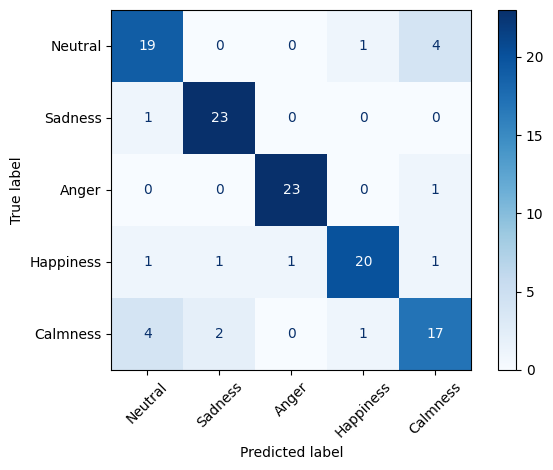

In [25]:
# Evaluate on test set
fusion.eval()

preds, _, _ = fusion(X_test_eeg.to(device), X_test_aud.to(device))
preds = preds.argmax(dim=1).cpu()

acc = accuracy_score(y_test_aud, preds) * 100
f1_macro = f1_score(y_test_aud, preds, average="macro")
f1_weighted = f1_score(y_test_aud, preds, average="weighted")
print(f"Test acc: {acc:.4f} | F1-macro: {f1_macro:.4f} | F1-weighted: {f1_weighted:.4f}")

cm = confusion_matrix(y_test_aud, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.tight_layout()
plt.show()


## Train (Backbones + GEGCN)

Backbones are unchanged. We now replace only the Co-GCN stage with the repository GEGCN framework
(`DeepMvNMF + Generator + Evaluator + GCN` from `train_and_test.py` / `model.py`).


### Build node indices and backbone-feature views


In [26]:
# Combine train+test into one node set (same setup you used for Co-GCN).
X_eeg_all = torch.cat([X_train_eeg, X_test_eeg], dim=0).to(device)
X_aud_all = torch.cat([X_train_aud, X_test_aud], dim=0).to(device)

y_train_t = torch.tensor(y_train, dtype=torch.long, device=device)
y_test_t = y_test_aud.to(device).long() if torch.is_tensor(y_test_aud) else torch.tensor(y_test_aud, dtype=torch.long, device=device)
y_all = torch.cat([y_train_t, y_test_t], dim=0)

n_train = len(y_train)
n_test = len(y_test_aud)
train_idx = torch.arange(0, n_train, device=device)
test_idx = torch.arange(n_train, n_train + n_test, device=device)

# GEGCN hyperparameters (reduced from script defaults for notebook runtime).
k = 10
common_neighbors = 2
pretrain_epochs = 500
train_epochs = 1000
log_every = 25

# Fine-tune stage hyperparameters (unfreeze backbones + low LR).
finetune_epochs = 60
finetune_lr = 1e-5
finetune_log_every = 10
finetune_rebuild_every = 10  # rebuild kNN graph every N fine-tune epochs

print(f"Nodes total={len(y_all)} | train/labeled={len(train_idx)} | test/eval={len(test_idx)}")


Nodes total=400 | train/labeled=280 | test/eval=120


### Freeze backbones, extract features, and build per-view kNN graphs


In [27]:
import scipy.sparse as sp
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from types import SimpleNamespace

from Dataloader import construct_adjacency_matrix
from model import DeepMvNMF, Generator, Evaluator, GCN

def set_requires_grad(model, flag: bool):
    for p in model.parameters():
        p.requires_grad = flag

def maybe_reduce_and_norm(feat_np, max_dim=512):
    # # Stabilizes graph construction for very high-dimensional backbone features.
    # feat_np = normalize(feat_np.astype(np.float32))
    # if feat_np.shape[1] > max_dim:
    #     n_comp = min(max_dim, feat_np.shape[0] - 1)
    #     if n_comp > 1:
    #         print(f"PCA: {feat_np.shape[1]} -> {n_comp}")
    #         feat_np = PCA(n_components=n_comp, random_state=42).fit_transform(feat_np).astype(np.float32)
    # return feat_np
    return normalize(feat_np.astype(np.float32))

# Keep backbones frozen for the first GEGCN pass (same intention as your frozen Co-GCN phase).
set_requires_grad(eeg_backbone, False)
set_requires_grad(aud_backbone, False)
eeg_backbone.eval()
aud_backbone.eval()

with torch.no_grad():
    _, feat_eeg = eeg_backbone(X_eeg_all, return_features=True)
    _, feat_aud = aud_backbone(X_aud_all, return_features=True)

feat_eeg_np = maybe_reduce_and_norm(feat_eeg.detach().cpu().numpy())
feat_aud_np = maybe_reduce_and_norm(feat_aud.detach().cpu().numpy())

adj_eeg = construct_adjacency_matrix(
    feat_eeg_np,
    k_nearest_neighobrs=k,
    prunning_one=True,
    prunning_two=True,
    common_neighbors=common_neighbors,
)
adj_aud = construct_adjacency_matrix(
    feat_aud_np,
    k_nearest_neighobrs=k,
    prunning_one=True,
    prunning_two=True,
    common_neighbors=common_neighbors,
)

feature_list = [
    torch.tensor(feat_eeg_np, dtype=torch.float32, device=device),
    torch.tensor(feat_aud_np, dtype=torch.float32, device=device),
]
adj_list = [
    torch.tensor(adj_eeg.todense(), dtype=torch.float32, device=device),
    torch.tensor(adj_aud.todense(), dtype=torch.float32, device=device),
]

print("Backbone feature shapes:", [tuple(v.shape) for v in feature_list])
print("Adjacency shapes:", [tuple(a.shape) for a in adj_list])


The construction of Laplacian matrix is finished!
The time cost of construction:  0.04729151725769043
The construction of Laplacian matrix is finished!
The time cost of construction:  0.34110116958618164
Backbone feature shapes: [(400, 240), (400, 2816)]
Adjacency shapes: [(400, 400), (400, 400)]


### GEGCN training loop (adapted from `train_and_test.py`)


In [28]:
def norm_2(x, y):
    return 0.5 * (torch.norm(x - y) ** 2)

def as_sparse(adj: torch.Tensor):
    return adj if adj.is_sparse else adj.to_sparse()

def train_gegcn_framework(
    feature_list,
    adj_list,
    labels,
    idx_labeled,
    idx_unlabeled,
    device,
    pretrain_epochs=300,
    num_epoch=250,
    dmf_lr=1e-3,
    generator_lr=1e-3,
    evaluator_lr=1e-2,
    gcn_lr=1e-2,
    weight_decay=5e-4,
    log_every=25,
):
    labels = labels.to(device).long()
    n_nodes = feature_list[0].shape[0]
    num_view = len(feature_list)
    num_classes = int(labels.max().item() + 1)

    # Union graph mask across views (same as repository training code).
    edge_mask = torch.zeros_like(adj_list[0], dtype=torch.bool, device=device)
    for adj in adj_list:
        edge_mask = edge_mask | adj.bool()

    coo = sp.coo_matrix(edge_mask.detach().cpu().numpy())
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long, device=device)

    # 1) DeepMvNMF pretraining to get shared representation z.
    input_dims = [feat.shape[1] for feat in feature_list]
    en_hidden_dims = [n_nodes, 128]
    dmf_model = DeepMvNMF(input_dims, en_hidden_dims, num_view, device).to(device)
    optimizer_dmf = torch.optim.Adam(dmf_model.parameters(), lr=dmf_lr, weight_decay=5e-5)
    identity = torch.eye(n_nodes, device=device).to_sparse()

    history = {
        'pretrain_loss': [],
        'loss_ce': [],
        'loss_g': [],
        'loss_d': [],
        'acc': [],
        'f1': [],
        'best_acc': 0.0,
        'best_f1': 0.0,
    }

    for epoch in range(1, pretrain_epochs + 1):
        shared_z, x_hat_list = dmf_model(identity)
        loss_dmf = sum(norm_2(feature_list[i], x_hat_list[i]) for i in range(num_view))

        optimizer_dmf.zero_grad()
        loss_dmf.backward()
        optimizer_dmf.step()

        history['pretrain_loss'].append(float(loss_dmf.item()))
        if epoch % log_every == 0 or epoch == 1:
            print(f"[Pretrain] Epoch {epoch:03d}/{pretrain_epochs} | Loss {loss_dmf.item():.4f}")

    shared_z = shared_z.detach()

    # 2) GEGCN modules.
    dummy_args = SimpleNamespace()
    generator = Generator(nfeat=shared_z.shape[1], nnodes=n_nodes, edgeidx=edge_index, device=device, args=dummy_args).to(device)
    evaluator = Evaluator(n_nodes).to(device)
    gcn_head = GCN(shared_z.shape[1], num_classes, device, dummy_args).to(device)

    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
    optimizer_evaluator = torch.optim.Adam(evaluator.parameters(), lr=evaluator_lr, weight_decay=weight_decay)
    optimizer_gcn = torch.optim.Adam(gcn_head.parameters(), lr=gcn_lr, weight_decay=weight_decay)

    loss_ce_fn = torch.nn.NLLLoss()
    loss_bce_fn = torch.nn.BCELoss()

    real_targets = torch.ones(n_nodes, 1, device=device)
    fake_targets = torch.zeros(n_nodes, 1, device=device)

    for epoch in range(1, num_epoch + 1):
        # (a) Shared step: DMF + classifier supervision.
        shared_z, x_hat_list = dmf_model(identity)
        generated_scores = generator(shared_z)
        generated_sparse = torch.sparse_coo_tensor(
            edge_index, generated_scores.flatten(), (n_nodes, n_nodes), device=device
        )
        adj_dense = generated_sparse.to_dense()

        logits, _ = gcn_head(adj_dense, shared_z)
        output = F.log_softmax(logits, dim=1)
        loss_ce = loss_ce_fn(output[idx_labeled], labels[idx_labeled])
        loss_dmf = sum(norm_2(feature_list[i], x_hat_list[i]) for i in range(num_view))

        optimizer_dmf.zero_grad()
        (loss_ce + loss_dmf).backward()
        optimizer_dmf.step()

        shared_z = shared_z.detach()

        # (b) Generator step.
        optimizer_generator.zero_grad()
        generated_scores = torch.sigmoid(generator(shared_z))
        generated_sparse = torch.sparse_coo_tensor(
            edge_index, generated_scores.flatten(), (n_nodes, n_nodes), device=device
        )
        adj_dense = generated_sparse.to_dense()

        logits, _ = gcn_head(adj_dense, shared_z)
        output = F.log_softmax(logits, dim=1)
        loss_ce_gen = loss_ce_fn(output[idx_labeled], labels[idx_labeled])

        dist_fake = evaluator(as_sparse(adj_dense))
        fake_diag = torch.diag(dist_fake).reshape(-1, 1)
        loss_g = loss_bce_fn(fake_diag, real_targets)

        (loss_g + loss_ce_gen).backward()
        optimizer_generator.step()

        # (c) Evaluator step.
        optimizer_evaluator.zero_grad()
        generated_scores = torch.sigmoid(generator(shared_z))
        generated_sparse = torch.sparse_coo_tensor(
            edge_index, generated_scores.flatten(), (n_nodes, n_nodes), device=device
        )
        dist_fake = evaluator(generated_sparse)
        fake_diag = torch.diag(dist_fake).reshape(-1, 1)

        real_scores = []
        for adj in adj_list:
            dist_real = evaluator(as_sparse(adj))
            real_scores.append(torch.diag(dist_real).reshape(-1, 1))

        loss_real = sum(loss_bce_fn(r, real_targets) / num_view for r in real_scores)
        loss_d = (loss_real + loss_bce_fn(fake_diag, fake_targets)) / 2.0
        loss_d.backward()
        optimizer_evaluator.step()

        # (d) GCN classifier step.
        gcn_head.train()
        adj_dense = generated_sparse.to_dense().detach()
        logits, _ = gcn_head(adj_dense, shared_z)
        output = F.log_softmax(logits, dim=1)
        loss_ce_step = loss_ce_fn(output[idx_labeled], labels[idx_labeled])

        optimizer_gcn.zero_grad()
        loss_ce_step.backward()
        optimizer_gcn.step()

        with torch.no_grad():
            pred = output.argmax(dim=1).detach().cpu().numpy()
            idx_eval = idx_unlabeled.detach().cpu().numpy()
            y_true_eval = labels[idx_unlabeled].detach().cpu().numpy()
            y_pred_eval = pred[idx_eval]
            acc = accuracy_score(y_true_eval, y_pred_eval)
            f1 = f1_score(y_true_eval, y_pred_eval, average='macro')

        history['loss_ce'].append(float(loss_ce_step.item()))
        history['loss_g'].append(float(loss_g.item()))
        history['loss_d'].append(float(loss_d.item()))
        history['acc'].append(float(acc))
        history['f1'].append(float(f1))

        if acc > history['best_acc']:
            history['best_acc'] = float(acc)
            history['best_f1'] = float(f1)

        if epoch % log_every == 0 or epoch == 1:
            print(
                f"[Train] Epoch {epoch:03d}/{num_epoch} | "
                f"L_ce {loss_ce_step.item():.4f} | L_g {loss_g.item():.4f} | L_d {loss_d.item():.4f} | "
                f"Eval ACC {acc*100:.2f}% | Best ACC {history['best_acc']*100:.2f}%"
            )

    return {
        'dmf_model': dmf_model,
        'generator': generator,
        'evaluator': evaluator,
        'gcn_head': gcn_head,
        'labels': labels,
        'idx_labeled': idx_labeled,
        'idx_unlabeled': idx_unlabeled,
        'edge_index': edge_index,
        'history': history,
    }


### Train GEGCN


In [29]:
gegcn_result = train_gegcn_framework(
    feature_list=feature_list,
    adj_list=adj_list,
    labels=y_all,
    idx_labeled=train_idx,
    idx_unlabeled=test_idx,
    device=device,
    pretrain_epochs=pretrain_epochs,
    num_epoch=train_epochs,
    log_every=log_every,
)

print(
    f"Best test-node ACC: {gegcn_result['history']['best_acc']*100:.2f}% | "
    f"Best test-node F1: {gegcn_result['history']['best_f1']*100:.2f}%"
)


[Pretrain] Epoch 001/500 | Loss 1156.4611
[Pretrain] Epoch 025/500 | Loss 325.0396
[Pretrain] Epoch 050/500 | Loss 273.6144
[Pretrain] Epoch 075/500 | Loss 216.7884
[Pretrain] Epoch 100/500 | Loss 179.2478
[Pretrain] Epoch 125/500 | Loss 153.6980
[Pretrain] Epoch 150/500 | Loss 136.0345
[Pretrain] Epoch 175/500 | Loss 123.9023
[Pretrain] Epoch 200/500 | Loss 114.5000
[Pretrain] Epoch 225/500 | Loss 107.4898
[Pretrain] Epoch 250/500 | Loss 99.0722
[Pretrain] Epoch 275/500 | Loss 89.0042
[Pretrain] Epoch 300/500 | Loss 82.9425
[Pretrain] Epoch 325/500 | Loss 79.9217
[Pretrain] Epoch 350/500 | Loss 76.6020
[Pretrain] Epoch 375/500 | Loss 74.8912
[Pretrain] Epoch 400/500 | Loss 73.4932
[Pretrain] Epoch 425/500 | Loss 72.4427
[Pretrain] Epoch 450/500 | Loss 71.5198
[Pretrain] Epoch 475/500 | Loss 70.3442
[Pretrain] Epoch 500/500 | Loss 69.6857
[Train] Epoch 001/1000 | L_ce 1.6036 | L_g 0.0034 | L_d 3.6466 | Eval ACC 25.83% | Best ACC 25.83%


[Train] Epoch 025/1000 | L_ce 0.8640 | L_g 0.0548 | L_d 2.1294 | Eval ACC 55.00% | Best ACC 56.67%
[Train] Epoch 050/1000 | L_ce 0.6886 | L_g 0.4475 | L_d 0.8608 | Eval ACC 55.00% | Best ACC 57.50%
[Train] Epoch 075/1000 | L_ce 0.4598 | L_g 1.0272 | L_d 0.6785 | Eval ACC 73.33% | Best ACC 73.33%
[Train] Epoch 100/1000 | L_ce 0.0568 | L_g 0.8526 | L_d 0.6515 | Eval ACC 80.00% | Best ACC 83.33%
[Train] Epoch 125/1000 | L_ce 0.0353 | L_g 0.9329 | L_d 0.6260 | Eval ACC 80.83% | Best ACC 83.33%
[Train] Epoch 150/1000 | L_ce 0.0357 | L_g 0.9611 | L_d 0.6109 | Eval ACC 77.50% | Best ACC 83.33%
[Train] Epoch 175/1000 | L_ce 0.0292 | L_g 0.9719 | L_d 0.6026 | Eval ACC 80.83% | Best ACC 83.33%
[Train] Epoch 200/1000 | L_ce 0.0314 | L_g 0.9649 | L_d 0.6001 | Eval ACC 82.50% | Best ACC 84.17%
[Train] Epoch 225/1000 | L_ce 0.0270 | L_g 0.9432 | L_d 0.6008 | Eval ACC 79.17% | Best ACC 84.17%
[Train] Epoch 250/1000 | L_ce 0.0250 | L_g 0.9124 | L_d 0.6033 | Eval ACC 82.50% | Best ACC 84.17%
[Train] Ep

### Frozen-stage metrics (ACC, F1, graphs, confusion matrix)


[Frozen] ACC: 83.3333% | F1-macro: 0.8248 | F1-weighted: 0.8248


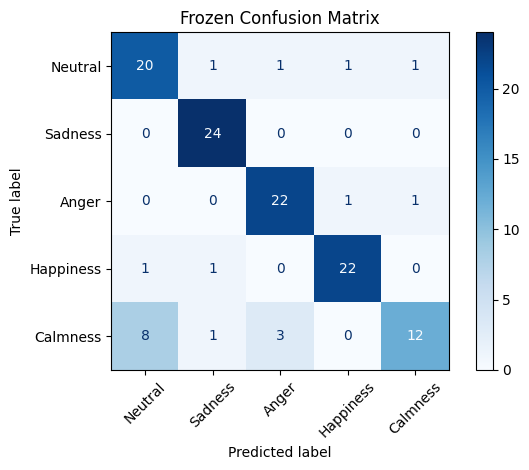

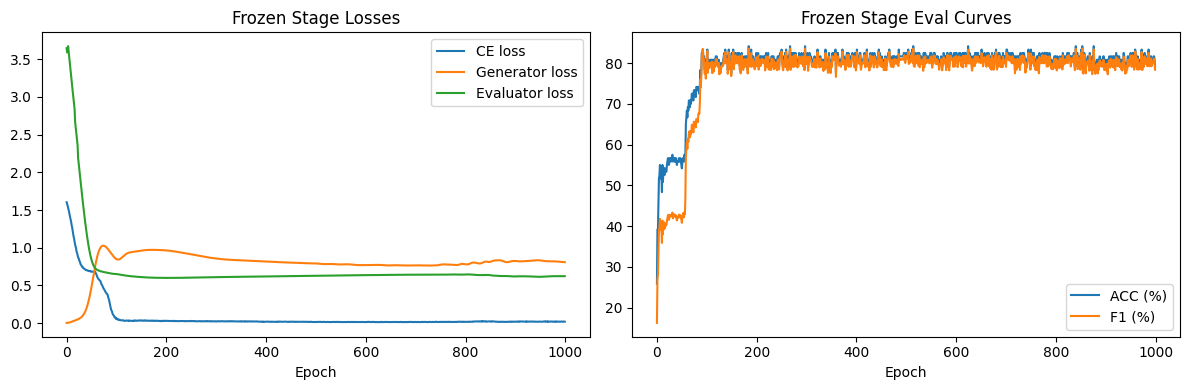

In [30]:
def evaluate_gegcn_stage(gegcn_result, stage_name="Stage"):
    """Evaluate current GEGCN modules and plot confusion matrix."""
    gegcn_result['dmf_model'].eval()
    gegcn_result['generator'].eval()
    gegcn_result['gcn_head'].eval()

    labels_all = gegcn_result['labels']
    idx_eval = gegcn_result['idx_unlabeled']
    n_nodes = labels_all.shape[0]
    identity = torch.eye(n_nodes, device=device).to_sparse()

    with torch.no_grad():
        shared_z, _ = gegcn_result['dmf_model'](identity)
        gen_scores = torch.sigmoid(gegcn_result['generator'](shared_z))
        gen_adj = torch.sparse_coo_tensor(
            gegcn_result['edge_index'],
            gen_scores.flatten(),
            (n_nodes, n_nodes),
            device=device,
        )
        logits, _ = gegcn_result['gcn_head'](gen_adj.to_dense(), shared_z)

    y_true = labels_all[idx_eval].detach().cpu().numpy()
    y_pred = logits[idx_eval].argmax(dim=1).detach().cpu().numpy()

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"[{stage_name}] ACC: {acc*100:.4f}% | F1-macro: {f1_macro:.4f} | F1-weighted: {f1_weighted:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"{stage_name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted}


def plot_stage_graphs(history, stage='frozen'):
    """Plot training curves for a specific stage."""
    if stage == 'frozen':
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history['loss_ce'], label='CE loss')
        plt.plot(history['loss_g'], label='Generator loss')
        plt.plot(history['loss_d'], label='Evaluator loss')
        plt.title('Frozen Stage Losses')
        plt.xlabel('Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(np.array(history['acc']) * 100, label='ACC (%)')
        plt.plot(np.array(history['f1']) * 100, label='F1 (%)')
        plt.title('Frozen Stage Eval Curves')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

    elif stage == 'finetune':
        if 'ft_loss_total' not in history or len(history['ft_loss_total']) == 0:
            print('No fine-tune history found. Run fine-tune cell first.')
            return

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history['ft_loss_total'], label='Total loss')
        plt.title('Fine-tune Loss')
        plt.xlabel('Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(np.array(history['ft_acc']) * 100, label='ACC (%)')
        plt.plot(np.array(history['ft_f1']) * 100, label='F1 (%)')
        plt.title('Fine-tune Eval Curves')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()


frozen_metrics = evaluate_gegcn_stage(gegcn_result, stage_name='Frozen')
plot_stage_graphs(gegcn_result['history'], stage='frozen')


### Fine-tune (unfreeze backbones, low LR)

In this stage, we unfreeze EEG/Audio backbones and jointly optimize backbones + GEGCN modules
with a small learning rate. Graph topology (`adj_list` / `edge_index`) is kept fixed.


In [31]:
def fine_tune_backbones_low_lr(
    gegcn_result,
    eeg_backbone,
    aud_backbone,
    X_eeg_all,
    X_aud_all,
    adj_list,
    k,
    common_neighbors,
    epochs=60,
    low_lr=1e-5,
    weight_decay=5e-4,
    lambda_g=0.2,
    lambda_d=0.2,
    rebuild_every=10,
    log_every=10,
):
    # Unfreeze backbones for end-to-end low-LR updates.
    set_requires_grad(eeg_backbone, True)
    set_requires_grad(aud_backbone, True)

    dmf_model = gegcn_result['dmf_model']
    generator = gegcn_result['generator']
    evaluator = gegcn_result['evaluator']
    gcn_head = gegcn_result['gcn_head']

    labels = gegcn_result['labels']
    idx_labeled = gegcn_result['idx_labeled']
    idx_unlabeled = gegcn_result['idx_unlabeled']
    edge_index = gegcn_result['edge_index']

    n_nodes = labels.shape[0]
    num_view = len(adj_list)
    identity = torch.eye(n_nodes, device=device).to_sparse()

    loss_ce_fn = nn.NLLLoss()
    loss_bce_fn = nn.BCELoss()
    real_targets = torch.ones(n_nodes, 1, device=device)
    fake_targets = torch.zeros(n_nodes, 1, device=device)

    # Mutable graph state during fine-tuning.
    adj_list_curr = [adj.detach().clone() for adj in adj_list]

    # Single low-LR optimizer over all trainable modules.
    params = (
        list(eeg_backbone.parameters())
        + list(aud_backbone.parameters())
        + list(dmf_model.parameters())
        + list(generator.parameters())
        + list(evaluator.parameters())
        + list(gcn_head.parameters())
    )
    optimizer = torch.optim.Adam(params, lr=low_lr, weight_decay=weight_decay)

    history = gegcn_result['history']
    history.setdefault('ft_loss_total', [])
    history.setdefault('ft_acc', [])
    history.setdefault('ft_f1', [])
    history.setdefault('ft_rebuild_epochs', [])

    def rebuild_knn_graph_from_backbones():
        """Recompute per-view kNN graphs from current backbone features."""
        eeg_backbone.eval()
        aud_backbone.eval()
        with torch.no_grad():
            _, feat_eeg_rb = eeg_backbone(X_eeg_all, return_features=True)
            _, feat_aud_rb = aud_backbone(X_aud_all, return_features=True)

        feat_eeg_np = maybe_reduce_and_norm(feat_eeg_rb.detach().cpu().numpy())
        feat_aud_np = maybe_reduce_and_norm(feat_aud_rb.detach().cpu().numpy())

        adj_eeg_rb = construct_adjacency_matrix(
            feat_eeg_np,
            k_nearest_neighobrs=k,
            prunning_one=True,
            prunning_two=True,
            common_neighbors=common_neighbors,
        )
        adj_aud_rb = construct_adjacency_matrix(
            feat_aud_np,
            k_nearest_neighobrs=k,
            prunning_one=True,
            prunning_two=True,
            common_neighbors=common_neighbors,
        )

        adj_list_rb = [
            torch.tensor(adj_eeg_rb.todense(), dtype=torch.float32, device=device),
            torch.tensor(adj_aud_rb.todense(), dtype=torch.float32, device=device),
        ]

        # Rebuild generator support (edge index) from union mask.
        edge_mask_rb = torch.zeros_like(adj_list_rb[0], dtype=torch.bool, device=device)
        for adj in adj_list_rb:
            edge_mask_rb = edge_mask_rb | adj.bool()

        coo_rb = sp.coo_matrix(edge_mask_rb.detach().cpu().numpy())
        edge_index_rb = torch.tensor(
            np.vstack((coo_rb.row, coo_rb.col)),
            dtype=torch.long,
            device=device,
        )
        return adj_list_rb, edge_index_rb

    for epoch in range(1, epochs + 1):
        # Periodic graph rebuild from updated backbone features.
        if rebuild_every > 0 and epoch % rebuild_every == 0:
            adj_list_curr, edge_index = rebuild_knn_graph_from_backbones()
            # Generator uses edge_index internally; keep it synchronized.
            generator.edge_index = edge_index
            generator.row, generator.col = edge_index
            history['ft_rebuild_epochs'].append(epoch)
            print(f"[Fine-tune] Rebuilt kNN graph at epoch {epoch} | edges={edge_index.shape[1]}")

        eeg_backbone.train()
        aud_backbone.train()
        dmf_model.train()
        generator.train()
        evaluator.train()
        gcn_head.train()

        # Dynamic features from unfrozen backbones (torch-normalized per sample).
        _, feat_eeg = eeg_backbone(X_eeg_all, return_features=True)
        _, feat_aud = aud_backbone(X_aud_all, return_features=True)
        feat_eeg = F.normalize(feat_eeg, p=2, dim=1)
        feat_aud = F.normalize(feat_aud, p=2, dim=1)

        shared_z, x_hat_list = dmf_model(identity)

        gen_scores = torch.sigmoid(generator(shared_z))
        gen_adj = torch.sparse_coo_tensor(
            edge_index,
            gen_scores.flatten(),
            (n_nodes, n_nodes),
            device=device,
        )
        adj_dense = gen_adj.to_dense()

        logits, _ = gcn_head(adj_dense, shared_z)
        output = F.log_softmax(logits, dim=1)

        # CE supervises labeled/train nodes.
        loss_ce = loss_ce_fn(output[idx_labeled], labels[idx_labeled])

        # Backbones are coupled via reconstruction targets.
        loss_dmf = norm_2(feat_eeg, x_hat_list[0]) + norm_2(feat_aud, x_hat_list[1])

        # Adversarial terms from repository framework.
        dist_fake = evaluator(as_sparse(adj_dense))
        fake_diag = torch.diag(dist_fake).reshape(-1, 1)
        loss_g = loss_bce_fn(fake_diag, real_targets)

        real_scores = []
        for adj in adj_list_curr:
            dist_real = evaluator(as_sparse(adj))
            real_scores.append(torch.diag(dist_real).reshape(-1, 1))
        loss_real = sum(loss_bce_fn(r, real_targets) / num_view for r in real_scores)
        loss_d = (loss_real + loss_bce_fn(fake_diag, fake_targets)) / 2.0

        total_loss = loss_ce + loss_dmf + lambda_g * loss_g + lambda_d * loss_d

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Eval on test nodes each epoch.
        eeg_backbone.eval()
        aud_backbone.eval()
        dmf_model.eval()
        generator.eval()
        gcn_head.eval()

        with torch.no_grad():
            shared_z_eval, _ = dmf_model(identity)
            gen_scores_eval = torch.sigmoid(generator(shared_z_eval))
            gen_adj_eval = torch.sparse_coo_tensor(
                edge_index,
                gen_scores_eval.flatten(),
                (n_nodes, n_nodes),
                device=device,
            )
            logits_eval, _ = gcn_head(gen_adj_eval.to_dense(), shared_z_eval)

            pred = logits_eval.argmax(dim=1).detach().cpu().numpy()
            idx_eval = idx_unlabeled.detach().cpu().numpy()
            y_true_eval = labels[idx_unlabeled].detach().cpu().numpy()
            y_pred_eval = pred[idx_eval]
            acc = accuracy_score(y_true_eval, y_pred_eval)
            f1 = f1_score(y_true_eval, y_pred_eval, average='macro')

        history['ft_loss_total'].append(float(total_loss.item()))
        history['ft_acc'].append(float(acc))
        history['ft_f1'].append(float(f1))

        if acc > history['best_acc']:
            history['best_acc'] = float(acc)
            history['best_f1'] = float(f1)

        if epoch % log_every == 0 or epoch == 1:
            print(
                f"[Fine-tune] Epoch {epoch:03d}/{epochs} | "
                f"L_total {total_loss.item():.4f} | "
                f"Eval ACC {acc*100:.2f}% | Best ACC {history['best_acc']*100:.2f}%"
            )

    # Save latest graph state for later evaluation calls.
    gegcn_result['edge_index'] = edge_index
    gegcn_result['adj_list'] = adj_list_curr
    return gegcn_result


gegcn_result = fine_tune_backbones_low_lr(
    gegcn_result=gegcn_result,
    eeg_backbone=eeg_backbone,
    aud_backbone=aud_backbone,
    X_eeg_all=X_eeg_all,
    X_aud_all=X_aud_all,
    adj_list=adj_list,
    k=k,
    common_neighbors=common_neighbors,
    epochs=finetune_epochs,
    low_lr=finetune_lr,
    rebuild_every=finetune_rebuild_every,
    log_every=finetune_log_every,
)

print(
    f"After fine-tune | Best test-node ACC: {gegcn_result['history']['best_acc']*100:.2f}% | "
    f"Best test-node F1: {gegcn_result['history']['best_f1']*100:.2f}%"
)


[Fine-tune] Epoch 001/60 | L_total 280.9800 | Eval ACC 83.33% | Best ACC 84.17%
The construction of Laplacian matrix is finished!
The time cost of construction:  0.04613947868347168
The construction of Laplacian matrix is finished!
The time cost of construction:  0.3415384292602539
[Fine-tune] Rebuilt kNN graph at epoch 10 | edges=9620
[Fine-tune] Epoch 010/60 | L_total 277.7119 | Eval ACC 81.67% | Best ACC 84.17%
The construction of Laplacian matrix is finished!
The time cost of construction:  0.04595828056335449
The construction of Laplacian matrix is finished!
The time cost of construction:  0.34415221214294434
[Fine-tune] Rebuilt kNN graph at epoch 20 | edges=9638
[Fine-tune] Epoch 020/60 | L_total 272.6140 | Eval ACC 81.67% | Best ACC 84.17%
The construction of Laplacian matrix is finished!
The time cost of construction:  0.045853614807128906
The construction of Laplacian matrix is finished!
The time cost of construction:  0.33992767333984375
[Fine-tune] Rebuilt kNN graph at epoch

The construction of Laplacian matrix is finished!
The time cost of construction:  0.04587960243225098
The construction of Laplacian matrix is finished!
The time cost of construction:  0.33841800689697266
[Fine-tune] Rebuilt kNN graph at epoch 50 | edges=9622
[Fine-tune] Epoch 050/60 | L_total 267.0895 | Eval ACC 81.67% | Best ACC 84.17%
The construction of Laplacian matrix is finished!
The time cost of construction:  0.04582786560058594
The construction of Laplacian matrix is finished!
The time cost of construction:  0.33766984939575195
[Fine-tune] Rebuilt kNN graph at epoch 60 | edges=9626
[Fine-tune] Epoch 060/60 | L_total 265.9811 | Eval ACC 82.50% | Best ACC 84.17%
After fine-tune | Best test-node ACC: 84.17% | Best test-node F1: 83.56%


### After Fine-tune metrics (ACC, F1, graphs, confusion matrix)


[Fine-tune] ACC: 82.5000% | F1-macro: 0.8171 | F1-weighted: 0.8171


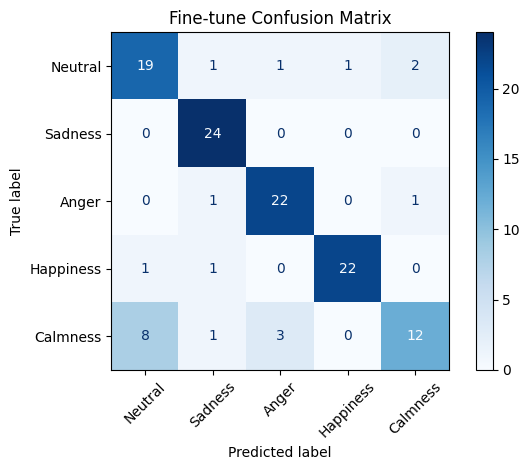

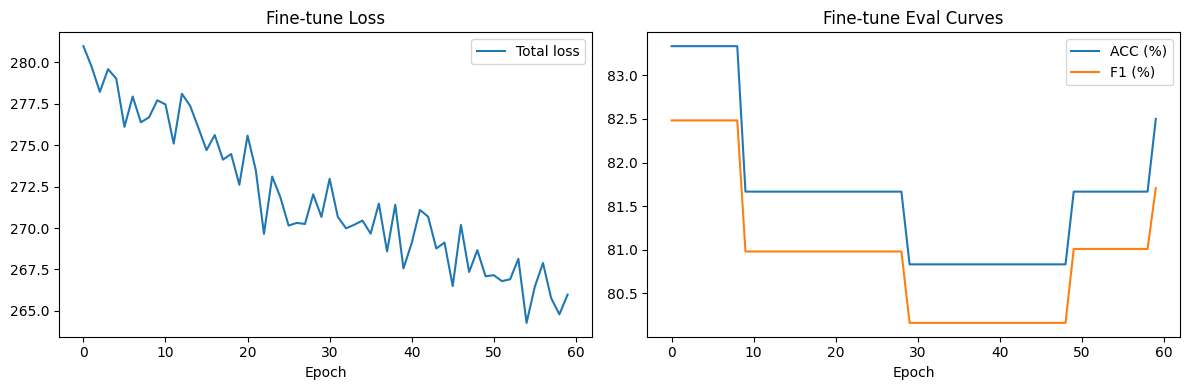

In [32]:
finetune_metrics = evaluate_gegcn_stage(gegcn_result, stage_name='Fine-tune')
plot_stage_graphs(gegcn_result['history'], stage='finetune')
